In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

!nvcc --version

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
from google.colab import files
uploaded = files.upload()

Saving custom_layers.py to custom_layers.py
Saving dataset.py to dataset.py
Saving util.py to util.py


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.autograd as autograd

import custom_layers as op
import util
import dataset as dset

import importlib
import custom_layers as op
importlib.reload(op)

<module 'custom_layers' from '/content/custom_layers.py'>

In [0]:
class generator(nn.Module):

    def __init__(self, dim_noise, dim_label, dim_output_img=64, n_channel=3):
        super(generator, self).__init__()

        inplace = True
        self.fc = nn.Linear(dim_noise , 64 * (16 ** 2))
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=inplace)
        self.block = nn.ModuleList([op.sr_resBlock(64) for _ in range(16)])
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=inplace)
        self.sub_pixel_deconv2d = nn.ModuleList([op.sub_pixel_deconv2d(2, 64) for _ in range(3)])
        self.conv = nn.Conv2d(64, n_channel, 9, 1, 4)
        self.tanh = nn.Tanh()

    def forward(self, nz, lb):
        x = torch.cat([nz, lb], 1)
        x = nz
        x = self.relu1(self.bn1(self.fc(x).view(-1, 64, 16, 16)))
        x_id = x
        for bk in self.block:
            x = bk(x)
        x = self.relu2(self.bn2(x)) + x_id
        for sub in self.sub_pixel_deconv2d:
            x = sub(x)
        x = self.tanh(self.conv(x))
        return x

class discriminator(nn.Module):

    def __init__(self, dim_input_img=128, n_channel = 3, dim_label = 10):
        super(discriminator, self).__init__()

        slope = 0.2
        inplace=True
        self.basic1 = nn.ModuleList([nn.Conv2d(n_channel, 32, 4, 2, 1), nn.LeakyReLU(slope, inplace)])
        self.basic1.extend([op.dis_resBlock(32) for _ in range(2)])
        
        self.basic2 = nn.ModuleList([nn.Conv2d(32, 64, 4, 2, 1), nn.LeakyReLU(slope, inplace)])
        self.basic2.extend([op.dis_resBlock(64) for _ in range(2)])
        
        self.basic3 = nn.ModuleList([nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(slope, inplace)])
        self.basic3.extend([op.dis_resBlock(128) for _ in range(2)])
        
        self.basic4 = nn.ModuleList([nn.Conv2d(128, 256, 3, 2, 1), nn.LeakyReLU(slope, inplace)])
        self.basic4.extend([op.dis_resBlock(256) for _ in range(2)])
        
        self.basic5 = nn.ModuleList([nn.Conv2d(256, 512, 3, 2, 1), nn.LeakyReLU(slope, inplace)])
        self.basic5.extend([op.dis_resBlock(512) for _ in range(2)])
        
        self.basic6 = nn.ModuleList([nn.Conv2d(512, 1024, 3, 2, 1), nn.LeakyReLU(slope, inplace)])
        
        self.block = nn.ModuleList([self.basic1, self.basic2, self.basic3, self.basic4, self.basic5, self.basic6])
        num_reduce_half = 6
        dim_final_kernel = int(dim_input_img / (2 ** num_reduce_half))
        self.flatten_size = 1024 * (dim_final_kernel ** 2)
        self.fc_score = nn.Linear(self.flatten_size, 1)
        self.fc_label = nn.Linear(self.flatten_size, dim_label)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        for bk in self.block:
            for bs in bk:
                x = bs(x)
        x = x.view(-1, self.flatten_size)
        x_score = self.sig(self.fc_score(x))
        #x_label = self.sig(self.fc_label(x))

        return x_score#, x_label

In [0]:
def dragan_penalty(discriminator, ip, scale, k, device, init_dist = 'uniform'):
    b_size = ip.size(0)
    alpha = None
    if init_dist == 'uniform':
        alpha = torch.empty(b_size, 1, 1, 1, device=device).uniform_(0, 1)
        alpha = alpha.expand(ip.size())
    else:
        alpha = torch.randn(b_size, 1, 1, 1, device=device).expand(ip.size())
    noise = 0.5 * ip.std() * torch.randn(ip.size(), device=device)
    input_nz = alpha * ip + (1 - alpha) * (ip + noise)
    input_nz.requires_grad_(True)
    output_nz = discriminator(input_nz).to(device)
    grad_nz = autograd.grad(output_nz, input_nz, torch.ones(output_nz.size(), device=device), \
        create_graph=True, retain_graph=True, only_inputs=True)[0]
    penalty = scale * ((grad_nz.norm(2, dim=1) - k)** 2).mean()
    return penalty


def train_base(epochs, batch_size, dim_noise, dim_label, device, dataset, generator, discriminator, loss, loss_class, optimizer_gen, optimizer_dis, filepath=None):
    # load the data
    bernoulli_idx=7
    worker = 2
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=worker)
    
    # create the list to store each loss
    loss_list, score_list, img_list = [], [], []
    num_fixed_ns_img = 64
    fixed_noise = torch.randn(num_fixed_ns_img, dim_noise, device=device)
    fixed_label = generate_random_label(num_fixed_ns_img, dim_label, bernoulli_idx, device=device)

    # start iterating the epoch
    for e in range(epochs):
        loss_dis, loss_gen, score_dis_real, score_dis_fake, score_gen = 0, 0, 0, 0, 0

        for i, data in enumerate(dataloader):
            b_size = batch_size
            if len(data[0]) < batch_size:
                b_size = len(data[0])
            # ---------------------------
            # 1. Train the discriminator
            # ---------------------------
            # generate noise samples from the generator
            batch_noise = torch.randn(b_size, dim_noise, device=device)
            batch_label = generate_random_label(b_size, dim_label, bernoulli_idx, device=device)
            fake_data = generator(batch_noise, batch_label)

            # start to train the discriminator
            discriminator.zero_grad()
            # calculate the loss of the noise samples, which assigns the same label 0
            # for all the samples, and get the single output(marks) from the discriminator
            output = discriminator(fake_data.detach())  # use .detach() to stop the requirement of gradient
            output = output.view(-1)
            class_label = torch.full((b_size,), 0, device=device)

            loss_d_ns_adv = loss(output, class_label)
            #loss_d_ns_cls = loss_class(output_label, batch_label)
            lambda_adv = 1 # dim_label
            loss_d_ns = lambda_adv * loss_d_ns_adv# + loss_d_ns_cls
            loss_d_ns.backward()
            score_dis_fake = output.mean().item()
            
            # calculate the loss of the real samples and assigns label 1 to represent
            # all samples are true and get the single output(marks) from the discriminator
            real_data = data[0].to(device)
            real_label = data[1].to(device)
            output = discriminator(real_data)
            #output_label = output_label.to(device)
            output = output.view(-1)
            class_label.fill_(1)
            loss_d_real_adv = loss(output, class_label)
            #loss_d_real_cls = loss_class(output_label, real_label)
            loss_d_real = lambda_adv * loss_d_real_adv# + loss_d_real_cls
            loss_d_real.backward()
            #loss_d_penelty = dragan_penalty(discriminator, real_data, 10, 1, device)
            
            # This is the part that compute the dragan gradient penalty
            # --------------------------------------------------------------
            scale, k = 10, 1
            alpha = torch.empty(b_size, 1, 1, 1, device=device).uniform_(0, 1)
            alpha = alpha.expand(real_data.size())
            noise = 0.5 * real_data.std() * torch.randn(real_data.size(), device=device)
            input_nz = alpha * real_data + (1 - alpha) * (real_data + noise)
            input_nz.requires_grad_(True)
            output_nz = discriminator(input_nz).to(device)
            grad_nz = autograd.grad(output_nz, input_nz, torch.ones(output_nz.size(), device=device), \
                create_graph=True, retain_graph=True, only_inputs=True)[0]
            loss_d_penelty = scale * ((grad_nz.norm(2, dim=1) - k)** 2).mean()
            # --------------------------------------------------------------
            
            loss_d_penelty.backward()
            loss_d = loss_d_ns + loss_d_real + loss_d_penelty
            score_dis_real = output.mean().item()
            loss_dis = loss_d.item()
            optimizer_dis.step()
            

            # ---------------------------
            # 2. Train the generator
            # ---------------------------
            # Feed the noise samplea to the discriminator agian to geit the accurate scores
            # after training the discriminator, and assign label 1 not to see the noise as
            # real label but to let the loss function to be correct and do correct back propogation
            generator.zero_grad()            
            # batch_noise = Func.torch.randn(b_size, dim_noise)
            # fake_data = generator(batch_noise)
            output = discriminator(fake_data)
            output = output.view(-1)
            loss_g_adv = loss(output, class_label)
            #loss_g_cls = loss_class(output_label, batch_label)
            loss_g = lambda_adv * loss_g_adv# + loss_g_cls
            loss_g.backward()
            score_gen = output.mean().item()
            loss_gen = loss_g.item()
            optimizer_gen.step()


            # print information to the console
            # print information 5 times in a epoch
            num2print = 50
            if (i + 1) % num2print == 0:
                print('epoch: %d, iter: %d, loss_D: %.4f, loss_G: %.4f;\t Scores: train D: D(x): %.4f, D(G(z)): %.4f train G: D(G(z))： %.4f, penalty: %.4f'
                        % (e, (i + 1), loss_dis, loss_gen, score_dis_real, score_dis_fake, score_gen, loss_d_penelty.item()))           
                
                # store the final loss for D and G for a specific time interval of a whole epoch
                loss_list.append([loss_dis, loss_gen])
                # store the final score from D for noise and real samples for a specific time imterval on current epoch
                score_list.append([score_dis_fake, score_dis_real, score_gen])

        loss_list.append([loss_dis, loss_gen])
        score_list.append([score_dis_fake, score_dis_real, score_gen])
        # store the image that the generator create for each epoch
        test_img = generator(fixed_noise, fixed_label)
        test_img = test_img.detach().cpu()
        img_list.append(test_img.numpy())

        # save the model
        if (e + 1) % 5 == 0:
            util.save_checkpoint(e + 1, generator, discriminator, loss_list, filepath)
    
    loss_list = list(map(list, zip(*loss_list)))
    score_list = list(map(list, zip(*score_list)))
        
    return generator, discriminator, loss_list, score_list, img_list

In [0]:
def generate_random_label(b_size, dim_label, bernoulli_idx, device):
    rand_label = torch.empty(b_size, dim_label, device=device)
    rand_label.uniform_(0, 1)
    if dim_label > 5:
        rand_label[:,7] = torch.bernoulli(rand_label[:,7])
    return rand_label

In [0]:
def init_weight(layer):
    std = 0.02
    if type(layer) == nn.ConvTranspose2d:
        nn.init.normal_(layer.weight.data, mean=0, std=std)
    elif type(layer) == nn.Conv2d:
        nn.init.normal_(layer.weight.data, mean=0, std=std)
    elif type(layer) == nn.Linear:
        nn.init.normal_(layer.weight.data, mean=0, std=std)
        nn.init.normal_(layer.bias.data, mean=0, std=std)
    elif type(layer) == nn.BatchNorm2d:
        nn.init.normal_(layer.weight.data, mean=1, std=std)
        nn.init.constant_(layer.bias.data, 0)

In [0]:
def build_gen_dis(config):
    net_gen = generator(config.DIM_NOISE, config.N_LABEL, config.DIM_IMG, config.N_CHANNEL).to(config.DEVICE)
    net_dis = discriminator(config.DIM_IMG, config.N_CHANNEL, config.N_LABEL).to(config.DEVICE)

    if config.INIT:
        net_gen.apply(init_weight)
        net_dis.apply(init_weight)
        loss = None
        print('initialize model successed')
    else:
        ext = config.PATH_MODEL[-4:]
        path_model = config.PATH_IMPORT_MODEL[:-4] + '_epoch_%d' % config.IMPORT_IDX_EPOCH
        print(path_model)
        path_model = path_model + ext
        print(path_model)
        if config.DEVICE == torch.device("cpu"):
            device = 'cpu'
        else:
            device = 'cuda:0'
        net_gen, net_dis, loss = util.load_checkpoint(config.EPOCHS, net_gen, net_dis, path_model, device)
        print("load model successed.")

    return net_gen, net_dis, loss

def train(dataset, net_gen, net_dis, config):

    # config = config.config_illustration_gan
    loss_class = nn.BCELoss().to(config.DEVICE)
    loss_label = nn.BCELoss().to(config.DEVICE)

    optim_gen = optim.Adam(net_gen.parameters(), lr=config.LEARNING_RATE, betas=(config.MOMENTUM, 0.99))
    optim_dis = optim.Adam(net_dis.parameters(), lr=config.LEARNING_RATE, betas=(config.MOMENTUM, 0.99))

    net_gen, net_dis, losses, _, imgs = train_base(config.EPOCHS, config.BATCH_SIZE, config.DIM_NOISE, config.N_LABEL, config.DEVICE,
                                                    dataset, net_gen, net_dis, loss_class, loss_label, optim_gen, optim_dis, config.PATH_MODEL)
    
    return net_gen, net_dis, losses, imgs

In [0]:
PATH_IMAGE = '/content/gdrive/My Drive/data/image_128'
PATH_TAG = '/content/gdrive/My Drive/data/tags'
ARTWORK_TYPE = os.listdir(PATH_IMAGE)
IS_ADD_I2V_TAG = False

class config_hr_anime_gan():
    PATH_MODEL = '/content/gdrive/My Drive/data/model/hr/hr_gan_e10.pth'
    IS_ADD_I2V_TAG = False
    BATCH_SIZE = 64
    DIM_IMG = 128
    DIM_NOISE = 100
    LEARNING_RATE = 0.0002
    MOMENTUM = 0.5
    EPOCHS = 40
    INIT = False
    IMPORT_IDX_EPOCH = 10
    DEVICE = torch.device("cuda:0")
    N_CHANNEL = 3
    N_LABEL = 5
    PATH_IMPORT_MODEL = '/content/gdrive/My Drive/data/model/hr//hr_gan.pth'


In [0]:
dataset = dset.pokemonDataset(PATH_IMAGE, PATH_TAG, ARTWORK_TYPE, is_add_i2v_tag=IS_ADD_I2V_TAG)
mean = [220.43362509, 217.50907014, 212.78514176]
std = [71.7985852,  73.64374336, 78.23258064]
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5 ,0.5, 0.5], [0.5, 0.5, 0.5])])
dataset.set_transform(transform)

In [0]:
CONFIG = config_hr_anime_gan
net_gen, net_dis, losses = build_gen_dis(CONFIG)
print(net_gen)
print(net_dis)
#print(losses)
net_gen, net_dis, losses, imgs = train(dataset, net_gen, net_dis, CONFIG)

/content/gdrive/My Drive/data/model/hr//hr_gan_epoch_10
/content/gdrive/My Drive/data/model/hr//hr_gan_epoch_10.pth
load model successed.
generator(
  (fc): Linear(in_features=100, out_features=16384, bias=True)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (block): ModuleList(
    (0): sr_resBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): sr_resBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu):

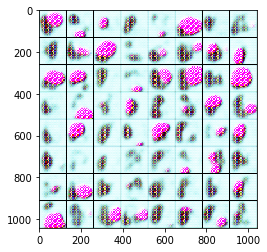

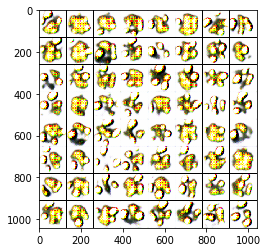

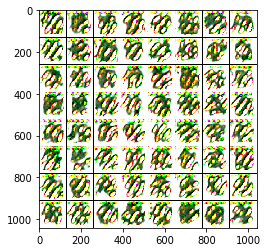

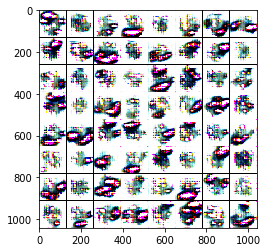

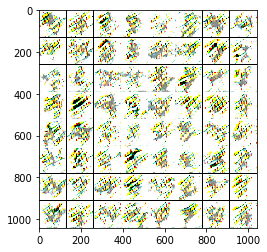

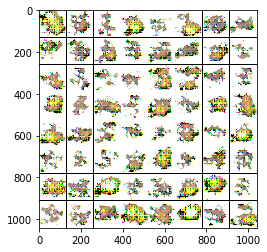

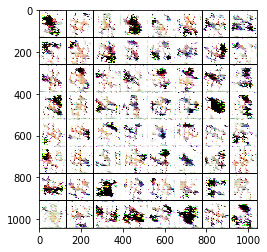

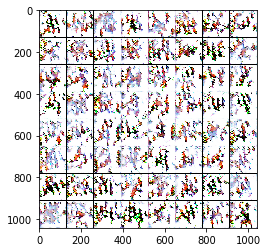

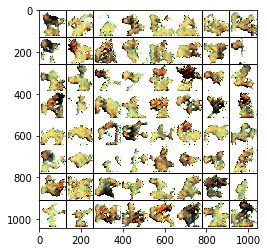

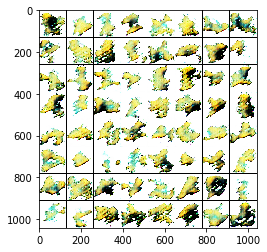

In [26]:
"""

CONFIG = config_hr_anime_gan
fixed_noise = torch.randn(64, 100, device=torch.device("cuda:0"))
fixed_label = generate_random_label(64, 5, 7, device=torch.device("cuda:0"))
for i in range(10):
    CONFIG.IMPORT_IDX_EPOCH = (i + 1) * 5
    net_gen, net_dis, losses = build_gen_dis(CONFIG)
    
    img = net_gen(fixed_noise, fixed_label)
    grid_img = util.make_figure_grid(img, 8)
    plt.figure()
    plt.imshow(grid_img)
    plt.imsave('/content/gdrive/My Drive/data/generate images/hrgan/hrgan_e%d.png' % ((i + 1) * 5), grid_img)
    plt.show()


plt.figure(figsize=(10, 5))
plt.plot(losses[0], label = 'generator')
plt.plot(losses[1], label = 'discriminator')
plt.title('Loss of training the gennerator and discriminator')
plt.xlabel('loss')
plt.ylabel('process')
plt.legend()
plt.show()
"""
for i in range(CONFIG.EPOCHS):
    grid_img = util.make_figure_grid(imgs[i], 8)
    plt.figure()
    plt.imshow(grid_img)
    plt.imsave('/content/gdrive/My Drive/data/generate images/hrgan/hrgan_e10_e%d.png' % i, grid_img)
plt.show()